# A simple engine for image searching: A [SimilaritySearch.jl](https://github.com/sadit/SimilaritySearch.jl) tutorial
## MNIST
by: Eric S. Tellez


## Installing packages
As usual, the first step consists on initializing the environment

In [1]:
using Pkg
pkg"activate ."
# pkg"add Printf MLDatasets LinearAlgebra Images StatsBase StatsPlots https://github.com/sadit/SimilaritySearch.jl"
using Printf, MLDatasets, MLDataUtils, LinearAlgebra, Images, StatsBase, StatsPlots, Statistics, SimilaritySearch


Activating environment at `~/Research/SimilaritySearch.jl/tutorials/Project.toml`


## Loading benchmarks
Here we use the [MNIST](https://juliaml.github.io/MLDatasets.jl/latest/datasets/MNIST/) dataset (loaded with MLDatasets).

## About preparing the data
As `SimilaritySearch.jl` works with several data types, we decide to work directly on the matrix input; however, we convert each image to a vector of Float32 values to achieve a small speedup and, mainly, to avoid overflow problems on direct computation over the `MLDatasets.jl`'s numeric encoding of both _MNIST_ and _Fashion-MNIST_.

In [2]:
function load_data()
    #train_X, train_y = FashionMNIST.traindata()
    #test_X, test_y = FashionMNIST.testdata()
    
    train_X, train_y = MNIST.traindata()
    test_X, test_y = MNIST.testdata()
    
    #vec(X, i) = Float32.(reshape(view(X, :, :, i), 28 * 28)) |> normalize!
    vec(X, i) = Float32.(view(X, :, :, i))
    
    dist = l2_distance

    X = [vec(train_X, i) for i in 1:60000]
    queries = [vec(test_X, i) for i in 1:10000]

    le = labelenc(train_y)
    train_y = label2ind.(train_y, le)
    test_y = label2ind.(test_y, le)
    (train_X=X, train_y=train_y, test_X=queries, test_y=test_y, dist=dist)
end

D = load_data()
size(D.train_X), size(D.test_X), typeof(D.train_X)

((60000,), (10000,), Array{Array{Float32,2},1})

## Visualizing
The following functions will display images in the notebook

In [3]:
display_one(m) = display(Gray.(reshape(m, 28, 28))')
display_many(arr) = display(Gray.(hcat([reshape(m, 28, 28)' for m in arr]...)))


display_many (generic function with 1 method)

## Searching demos

The first demo is made with an exhaustive search; this algorithm is pretty simple but low performant; it is indicated whenever the construction time can't be amortized by the number of queries.

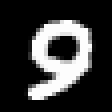

results (obj => dist): 58471 => 6.30, 24122 => 6.42, 20642 => 6.93, 42716 => 6.95, 6974 => 7.04, 18424 => 7.09, 18490 => 7.11, 23972 => 7.12, 26824 => 7.15, 8810 => 7.17, 58470 => 7.23, 931 => 7.23, 45006 => 7.30, 56247 => 7.34, 1320 => 7.37

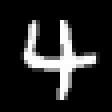

  0.062529 seconds (86.15 k allocations: 4.631 MiB)


results (obj => dist): 39047 => 4.98, 23475 => 5.57, 41781 => 5.59, 46468 => 5.65, 32449 => 5.68, 48390 => 5.75, 40607 => 5.86, 4514 => 5.91, 48203 => 5.94, 34206 => 5.99, 40934 => 5.99, 54172 => 6.01, 24275 => 6.02, 19027 => 6.04, 8651 => 6.07

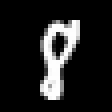

results (obj => dist): 34670 => 4.19, 55969 => 4.44, 23437 => 4.60, 49809 => 4.63, 5477 => 4.69, 18374 => 4.73, 45707 => 4.87, 14994 => 4.93, 37460 => 4.94, 47965 => 4.94, 12623 => 4.94, 5347 => 4.94, 54927 => 4.98, 34873 => 5.01, 24188 => 5.06

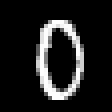

results (obj => dist): 52229 => 3.89, 49531 => 3.95, 29389 => 4.43, 23989 => 4.73, 37823 => 4.82, 30425 => 4.85, 29375 => 5.01, 49279 => 5.05, 41923 => 5.05, 8725 => 5.06, 10701 => 5.08, 53510 => 5.10, 25153 => 5.12, 44131 => 5.17, 13529 => 5.21

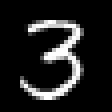

results (obj => dist): 18275 => 4.33, 8968 => 4.48, 1810 => 4.53, 7502 => 4.54, 30259 => 4.62, 56967 => 4.68, 56739 => 4.80, 2264 => 4.87, 21210 => 4.87, 47028 => 4.89, 14793 => 4.91, 16794 => 4.98, 7434 => 4.99, 10331 => 5.01, 54344 => 5.02

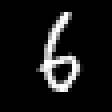

  0.019479 seconds (3 allocations: 368 bytes)
  0.021148 seconds (3 allocations: 368 bytes)
  0.020783 seconds (3 allocations: 368 bytes)
  0.020030 seconds (3 allocations: 368 bytes)


results (obj => dist): 32593 => 3.42, 4829 => 3.52, 24305 => 3.54, 15709 => 3.57, 23199 => 3.57, 4269 => 3.77, 46383 => 3.83, 46685 => 3.86, 28509 => 3.87, 10485 => 3.89, 56583 => 3.90, 44411 => 3.94, 40125 => 3.95, 53423 => 4.00, 1507 => 4.01

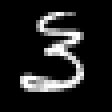

results (obj => dist): 3172 => 6.42, 49561 => 6.51, 38868 => 6.52, 49468 => 6.52, 50373 => 6.60, 44193 => 6.62, 37607 => 6.63, 24970 => 6.66, 36803 => 6.68, 27676 => 6.68, 20566 => 6.68, 25034 => 6.71, 51948 => 6.71, 547 => 6.72, 44672 => 6.77

  0.021631 seconds (3 allocations: 368 bytes)
  0.020785 seconds (3 allocations: 368 bytes)


In [4]:
function sequential_search_demo()
    index = fit(Sequential, D.train_X)

    for q in rand(D.test_X, 7)
        display_one(q)
        @time res = search(index, D.dist, q, KnnResult(15))
        display_many(D.train_X[[p.objID for p in res]])
        msg = [(@sprintf "%d => %0.2f" p.objID p.dist) for p in res]
        display("text/html", "results (obj => dist): " * join(msg, ", "))
    end
    
    index
end

seq = sequential_search_demo();

## Searching with faster indexes
Fast exact indexes can be created using metric division strategies, but the faster ones some times are designed to retrieve an approximation of the solution. In any case, indexes for fast similarity search need to amortize the construction cost with a large number of queries. The following functions only exemplify the searching process, however, the number of queries is too small to show the typical case of use of these indexes.

## Experiments with a K-Nearest References index (Knr)

The `Knr` is a simple but effective index that allows fast searching in high dimensional datasets.

Knr> refs=Array{Array{Float32,2},1}, k=3, numrefs=128, dist=l2_distance
Knr> advance 0.05, now: 2019-11-19T15:18:25.045
Knr> advance 0.1, now: 2019-11-19T15:18:25.135
Knr> advance 0.15, now: 2019-11-19T15:18:25.213
Knr> advance 0.2, now: 2019-11-19T15:18:25.288
Knr> advance 0.25, now: 2019-11-19T15:18:25.365
Knr> advance 0.3, now: 2019-11-19T15:18:25.442
Knr> advance 0.35, now: 2019-11-19T15:18:25.527
Knr> advance 0.4, now: 2019-11-19T15:18:25.604
Knr> advance 0.45, now: 2019-11-19T15:18:25.677
Knr> advance 0.5, now: 2019-11-19T15:18:25.75
Knr> advance 0.55, now: 2019-11-19T15:18:25.828
Knr> advance 0.6, now: 2019-11-19T15:18:25.908
Knr> advance 0.65, now: 2019-11-19T15:18:25.986
Knr> advance 0.7, now: 2019-11-19T15:18:26.06
Knr> advance 0.75, now: 2019-11-19T15:18:26.139
Knr> advance 0.8, now: 2019-11-19T15:18:26.216
Knr> advance 0.85, now: 2019-11-19T15:18:26.294
Knr> advance 0.9, now: 2019-11-19T15:18:26.384
Knr> advance 0.95, now: 2019-11-19T15:18:26.468


  1.929818 seconds (868.15 k allocations: 49.360 MiB, 1.79% gc time)


Knr> advance 1.0, now: 2019-11-19T15:18:26.545
Knr> optimizing index for recall=0.95
Knr> opt step ksearch=2, performance PerformanceResult(0.8350694444444441, 0.8350694444444441, 0.8350694444444441, 0.0022754985839128494, 0.01836998388171196, 3304.46875, 5556.603407086479)
Knr> opt step ksearch=3, performance PerformanceResult(0.9305555555555551, 0.9305555555555551, 0.9305555555555551, 0.0029545780271291733, 0.01836998388171196, 5338.4765625, 5499.251984503071)


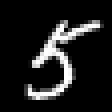

results (obj => dist): 33556 => 5.16, 43524 => 5.17, 6692 => 5.17, 10112 => 5.21, 58714 => 5.31, 31490 => 5.36, 43452 => 5.39, 46760 => 5.43, 59868 => 5.45, 33735 => 5.64, 16425 => 5.70, 44692 => 5.72, 11487 => 5.75, 44774 => 5.79, 59347 => 5.80

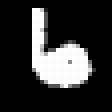

  0.034564 seconds (24.27 k allocations: 1.314 MiB)


Knr> reached performance PerformanceResult(0.973958333333333, 0.973958333333333, 0.973958333333333, 0.0039166416972875595, 0.01836998388171196, 7285.6875, 5479.599982705027)


results (obj => dist): 41345 => 5.30, 48859 => 5.38, 48431 => 5.40, 17653 => 5.60, 1505 => 5.92, 19948 => 5.96, 59418 => 6.01, 14156 => 6.11, 48777 => 6.16, 59360 => 6.19, 10977 => 6.24, 14722 => 6.25, 14672 => 6.26, 14072 => 6.50, 23416 => 6.56

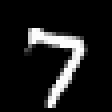

results (obj => dist): 59247 => 3.83, 8437 => 3.85, 23268 => 3.89, 49175 => 4.12, 46766 => 4.17, 31399 => 4.21, 48830 => 4.23, 43841 => 4.24, 58527 => 4.25, 50148 => 4.28, 52011 => 4.31, 42095 => 4.35, 33308 => 4.38, 56075 => 4.38, 52607 => 4.46

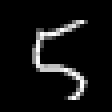

results (obj => dist): 36127 => 5.69, 55749 => 5.69, 15577 => 5.74, 38363 => 5.75, 44431 => 5.86, 50042 => 5.99, 4597 => 6.02, 47665 => 6.04, 6371 => 6.04, 49553 => 6.05, 42437 => 6.18, 51157 => 6.18, 17613 => 6.19, 23905 => 6.21, 23945 => 6.21

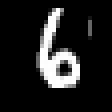

results (obj => dist): 38191 => 3.41, 1695 => 3.48, 41779 => 4.12, 48341 => 4.20, 39122 => 4.23, 45511 => 4.28, 54151 => 4.30, 17868 => 4.34, 49901 => 4.34, 53231 => 4.42, 57315 => 4.57, 44743 => 4.59, 57884 => 4.60, 56886 => 4.60, 13773 => 4.61

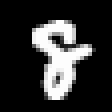

results (obj => dist): 16956 => 5.24, 313 => 5.54, 48553 => 5.65, 3159 => 5.87, 4678 => 5.89, 26949 => 5.92, 10593 => 5.97, 44605 => 5.97, 29304 => 5.98, 17171 => 6.03, 23289 => 6.07, 43323 => 6.08, 21105 => 6.15, 53083 => 6.20, 4692 => 6.27

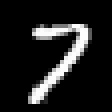

results (obj => dist): 11077 => 3.60, 20584 => 3.75, 56018 => 3.86, 38092 => 3.91, 20336 => 3.96, 19154 => 4.13, 20224 => 4.22, 2428 => 4.31, 3888 => 4.32, 6141 => 4.35, 19200 => 4.36, 17484 => 4.38, 18874 => 4.40, 3168 => 4.44, 8206 => 4.46

  0.001432 seconds (9 allocations: 117.828 KiB)
  0.004205 seconds (9 allocations: 117.828 KiB)
  0.003523 seconds (9 allocations: 117.828 KiB)
  0.005309 seconds (9 allocations: 117.828 KiB)
  0.002336 seconds (9 allocations: 117.828 KiB)
  0.004276 seconds (9 allocations: 117.828 KiB)


In [5]:
function knr_search_demo()
    @time index = fit(Knr, D.dist, D.train_X, numrefs=128, verbose=true)
    # we can optimize the index to achieve a desired quality (trading with search time)
    optimize!(index, D.dist, recall=0.95)
    
    for q in rand(D.test_X, 7)
        display_one(q)
        @time res = search(index, D.dist, q, KnnResult(15))
        display_many([D.train_X[p.objID] for p in res])
        msg = [(@sprintf "%d => %0.2f" p.objID p.dist) for p in res]
        display("text/html", "results (obj => dist): " * join(msg, ", "))
    end
    
    index
end

knr = knr_search_demo();

## Solving queries with a proximity search graph
The `SearchGraph` is a faster index but with a more expensive construction.

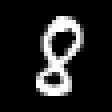

 21.699451 seconds (22.31 M allocations: 2.362 GiB, 3.75% gc time)
 

results (obj => dist): 54594 => 4.35, 3154 => 4.62, 59885 => 4.85, 26584 => 4.87, 58509 => 4.90, 43788 => 4.95, 50926 => 5.01, 30824 => 5.05, 46122 => 5.09, 11663 => 5.10, 13724 => 5.12, 53766 => 5.16, 31000 => 5.29, 58297 => 5.32, 52574 => 5.33

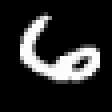

results (obj => dist): 14148 => 4.86, 31221 => 5.16, 21453 => 5.30, 51729 => 5.42, 9203 => 5.70, 45301 => 5.87, 14110 => 6.06, 16431 => 6.12, 50557 => 6.18, 43683 => 6.34, 14779 => 6.42, 42155 => 6.42, 14130 => 6.45, 45377 => 6.45, 40829 => 6.54

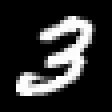

results (obj => dist): 33050 => 5.73, 40006 => 5.85, 33170 => 5.89, 16172 => 5.99, 55018 => 6.01, 15786 => 6.08, 34722 => 6.23, 53036 => 6.27, 30516 => 6.32, 42252 => 6.33, 12334 => 6.43, 42138 => 6.44, 12452 => 6.46, 33010 => 6.52, 39596 => 6.57

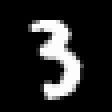

results (obj => dist): 50365 => 4.44, 24105 => 4.47, 45787 => 4.47, 16079 => 4.54, 75 => 4.75, 37455 => 4.81, 41903 => 4.82, 6099 => 4.84, 54407 => 4.97, 11011 => 5.03, 7107 => 5.18, 32285 => 5.22, 47835 => 5.28, 34537 => 5.28, 14088 => 5.29

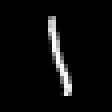

results (obj => dist): 40465 => 2.01, 46719 => 2.06, 7877 => 2.17, 44725 => 2.24, 26503 => 2.25, 23873 => 2.30, 1453 => 2.35, 53967 => 2.36, 5337 => 2.41, 20299 => 2.42, 30685 => 2.48, 31571 => 2.51, 27389 => 2.53, 8383 => 2.53, 55287 => 2.56

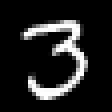

results (obj => dist): 32690 => 5.33, 9141 => 5.34, 49967 => 5.59, 32800 => 5.64, 48933 => 5.67, 38242 => 5.70, 3684 => 5.70, 32776 => 5.78, 42842 => 5.85, 15337 => 5.98, 56449 => 6.01, 21285 => 6.02, 14457 => 6.18, 10883 => 6.21, 21623 => 6.24

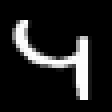

results (obj => dist): 58019 => 5.97, 24297 => 6.23, 54467 => 6.65, 50845 => 6.69, 19099 => 6.72, 21271 => 6.75, 7959 => 6.78, 27078 => 6.96, 4788 => 7.02, 22277 => 7.07, 50637 => 7.12, 9411 => 7.14, 56700 => 7.27, 15433 => 7.28, 53427 => 7.33

 0.000591 seconds (20 allocations: 19.484 KiB)
  0.000361 seconds (20 allocations: 19.484 KiB)
  0.000451 seconds (20 allocations: 19.484 KiB)
  0.000493 seconds (20 allocations: 19.484 KiB)
  0.000373 seconds (20 allocations: 19.484 KiB)
  0.000226 seconds (20 allocations: 19.484 KiB)
  0.000228 seconds (20 allocations: 19.484 KiB)


In [6]:
function searchgraph_search_demo()
    # a real index only works whenever the number of queries amortizes the construction cost
    @time index = fit(SearchGraph, D.dist, D.train_X, verbose=false)
    optimize!(index, D.dist, recall=0.95)
    for q in rand(D.test_X, 7)
        display_one(q)
        @time res = search(index, D.dist, q, KnnResult(15))
        display_many([D.train_X[p.objID] for p in res])
        msg = [(@sprintf "%d => %0.2f" p.objID p.dist) for p in res]
        display("text/html", "results (obj => dist): " * join(msg, ", "))
    end
    
    index
end

sgraph = searchgraph_search_demo();

## A simple KNN classifier
Lets create a classifier to measure the performance and the quality impact of the different indexes

In [7]:
function classify(index, k=1, dist=D.dist)
    ypred = []
    @time for i in eachindex(D.test_X)
        res = search(index, dist, D.test_X[i], KnnResult(k))
        if k == 1
            push!(ypred, D.train_y[first(res).objID])
        else
            labels = D.train_y[[p.objID for p in res]]
            c = counts(labels, 1:10)
            push!(ypred, findmax(c)[end])
        end
    end
    
    display("text/html", "$(k)NN-classifier $(typeof(index)), accuracy: $(mean(ypred .== D.test_y))")
end


classify (generic function with 3 methods)

In [8]:
classify(seq)
classify(knr)
classify(sgraph)

1NN-classifier Sequential{Array{Float32,2}}, accuracy: 0.9691

198.971209 seconds (69.05 k allocations: 2.836 MiB)
 

1NN-classifier Knr{Array{Float32,2}}, accuracy: 0.9681

42.494891 seconds (128.92 k allocations: 1.123 GiB, 0.51% gc time)


1NN-classifier SearchGraph{Array{Float32,2}}, accuracy: 0.9575

  3.345909 seconds (239.61 k allocations: 200.080 MiB, 1.13% gc time)


### Optimizing the index for speed
As commented, it is possible to trade quality by speed, and this can be made not just for different indexes. 

In [9]:
for recall in [0.7, 0.8, 0.9, 0.95, 0.99]
    optimize!(sgraph, l2_distance, recall=recall, k=3)
    display("text/html", "testing for recall $recall")
    classify(sgraph)
end


testing for recall 0.7

1NN-classifier SearchGraph{Array{Float32,2}}, accuracy: 0.9022

testing for recall 0.8

  1.401374 seconds (229.16 k allocations: 145.540 MiB, 1.35% gc time)


1NN-classifier SearchGraph{Array{Float32,2}}, accuracy: 0.9037

testing for recall 0.9

  1.514027 seconds (229.40 k allocations: 146.582 MiB, 1.26% gc time)
 

1NN-classifier SearchGraph{Array{Float32,2}}, accuracy: 0.9014

testing for recall 0.95

 1.382167 seconds (229.60 k allocations: 147.375 MiB, 1.31% gc time)


1NN-classifier SearchGraph{Array{Float32,2}}, accuracy: 0.9603

testing for recall 0.99

  3.022382 seconds (240.98 k allocations: 217.506 MiB, 0.90% gc time)
 

1NN-classifier SearchGraph{Array{Float32,2}}, accuracy: 0.9637

 3.622478 seconds (245.21 k allocations: 272.401 MiB, 0.86% gc time)


## Changing the distance function on-the-go

It is possible to use different distance functions over an already created index; some indexes will work fine, taking a little different notion of similarity while searching. Note that the expected performance could change. However, it allows us to explore rapidly over new similarity measures or functions computationally more expensive (preventing that creating the index become a time cons procedure).

In the following examples, we use non-linear functions that barely improve over the Euclidean distance; nevertheless, these exercise exemplifies that it is possible to hand tune a distance function on-the-go.

In [12]:
function dist1(a, b)
    d = 0.0
    @inbounds @fastmath @simd for i in 1:length(a)
        m = abs(a[i] - b[i])
        if m > 0.3
            d += m^5
        end
    end
    
    d #sqrt(d)
end

display("text/markdown", "### Predicting with a more costly distance")

# While we can optimize for any function, and we should expect better results
# it may took too much time, so we use l2_distance function 
optimize!(sgraph, l2_distance, recall=0.999)
for k in [1, 3, 5]
    classify(sgraph, k, dist1)
end



### Predicting with a more costly distance

1NN-classifier SearchGraph{Array{Float32,2}}, accuracy: 0.9708

 18.255753 seconds (403.83 k allocations: 598.055 MiB, 0.34% gc time)
 

3NN-classifier SearchGraph{Array{Float32,2}}, accuracy: 0.9724

18.108968 seconds (319.66 k allocations: 596.103 MiB, 0.34% gc time)


5NN-classifier SearchGraph{Array{Float32,2}}, accuracy: 0.9724

 17.886243 seconds (319.83 k allocations: 598.761 MiB, 0.36% gc time)


# Conclusions
In this tutorial we reviwed how to create a simple search by content indexes for the MNIST dataset.
We also present the difference in performance among three different structures while quality is traded by speed
using the search indexes as KNN classifiers. 
Finally, we shown how to use a different distance functions to hand tune the classifier.  